In [1]:
%matplotlib inline

import numpy as np 
import matplotlib.pyplot as plt

# convert from arcseconds to radians
arcsec = np.pi / (180.0 * 3600) # [radians]  = 1/206265 radian/arcsec

# PyMC3 in the Fourier Plane

Let's take a gander at implementing a PyMC3 model to sample a visibility model. For simplicity's sake, we'll keep everything 1D for now. 

$$
    I(\alpha |\, \boldsymbol{\beta}) = a \exp \left [ -  \frac{(\alpha^\prime - \delta_\alpha)^2}{2 \sigma_\alpha^2} \right ]
$$

then the model visibility function (via Fourier transform pairs) is

$$
    V(u |\, \boldsymbol{\beta}) = a e^{- 2 \pi \imath \delta_\alpha u^\prime} \exp \left [ -2 \sigma_\alpha^2 u^{\prime 2} \right ].
$$

Let's implement this sky plane model 

In [2]:
def sky_plane(alpha, a=1, delta_alpha=0.0, sigma_alpha=1.0*arcsec):
    '''
    a : amplitude
    delta_alpha : offset (in radians)
    sigma_alpha : width (in radians)
    '''
    
    return a * np.exp(-(alpha - delta_alpha)**2/(2 * sigma_alpha**2))

In [18]:
def fftspace(width, N):
    '''Oftentimes it is necessary to get a symmetric coordinate array that spans ``N``
     elements from `-width` to `+width`, but makes sure that the middle point lands
     on ``0``. The indices go from ``0`` to ``N -1.``
     `linspace` returns  the end points inclusive, wheras we want to leave out the
     right endpoint, because we are sampling the function in a cyclic manner.'''

    assert N % 2 == 0, "N must be even."

    dx = width * 2.0 / N
    xx = np.empty(N, np.float64)
    for i in range(N):
        xx[i] = -width + i * dx
    
    return xx

Text(0, 0.5, '$I$')

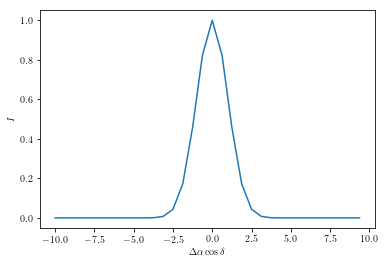

In [19]:
# Let's plot this up and see what it looks like 

N_alpha = 32 
img_radius = 10.0 * arcsec


# full span of the image
ras = fftspace(img_radius, N_alpha) # [arcsec]

# fill out an image 
ys = np.empty(N_alpha, np.float64)

for i,alpha in enumerate(ras):
    ys[i] = sky_plane(alpha)

plt.plot(ras/arcsec, ys)
plt.xlabel(r"$\Delta \alpha \cos \delta$")
plt.ylabel(r"$I$")

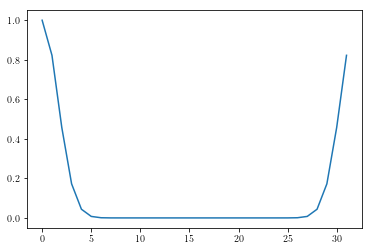

In [20]:
plt.plot(np.fft.fftshift(ys))

In [6]:
vis = np.fft.ifftshift(np.fft.fft(np.fft.fftshift(ys)))
freqs = np.fft.ifftshift(np.fft.fftfreq(N_alpha, img_radius/(N_alpha)))

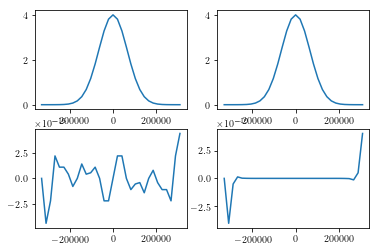

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=2)

ax[0,0].plot(freqs, np.real(vis))
ax[1,0].plot(freqs, np.imag(vis))

ax[0,1].plot(freqs, np.abs(vis))
ax[1,1].plot(freqs, 180 / np.pi * np.angle(vis))

In [8]:
noise = 0.1 # Jy

In [9]:
np.random.seed(42)

# create a dataset off of this, by adding noise to the real and imaginary parts
# i.e., we need two noise draws
data = vis + np.random.normal(loc=0, scale=noise, size=(N_alpha)) + \
    np.random.normal(loc=0, scale=noise, size=(N_alpha)) * 1.0j 

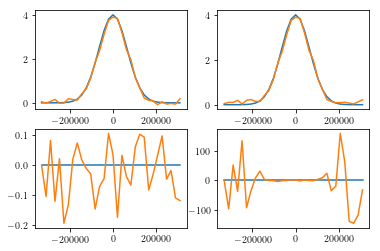

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=2)

ax[0,0].plot(freqs, np.real(vis))
ax[0,0].plot(freqs, np.real(data))

ax[1,0].plot(freqs, np.imag(vis))
ax[1,0].plot(freqs, np.imag(data))

ax[0,1].plot(freqs, np.abs(vis))
ax[0,1].plot(freqs, np.abs(data))

ax[1,1].plot(freqs, 180 / np.pi * np.angle(vis))
ax[1,1].plot(freqs, 180 / np.pi * np.angle(data))

# Implementing this model in Theano

Now that we have a dataset, the challenging part is figuring out how to use PyMC3 and actually fit this with Theano. Let's start by implementing something `fft`ed with the Theano docs http://deeplearning.net/software/theano/library/tensor/fft.html to see if we have that part down

In [59]:
def rfft_to_full(rfft_out):
    '''
    Take rfft output (corresponding only to positive spatial frequencies) and duplicate it such that we 
    would have output corresponding to all frequencies.
    '''
    
    # 1D example 
    N = len(rfft_out)
    N_out = 2 * (N - 1)
    c_out = np.empty(N_out, dtype=np.complex128)
    
    c_out[N-1:] = rfft_out[:-1]
    c_out[:N-1] = np.conj(rfft_out[1:])[::-1] # could allocate the conj directly to array

    return c_out

In [60]:
rfft_to_full(c_out);

In [61]:
import theano
import theano.tensor as T
from theano.tensor import fft


# define the Theano operation
x = T.matrix('x', dtype='float64')

rfft = fft.rfft(x, norm=None)
f_rfft = theano.function([x], rfft)


# put in our Gaussian function, appropriately packed 
box = np.zeros((1, N_alpha), dtype=np.float64) # shape (1, 32) because that's what Theano requires
box[:] = np.fft.fftshift(ys)

out = f_rfft(box)
# out has dimensions of (1, N_alpha/2 + 1,2)

c_out = np.asarray(out[0, :, 0] + 1j*out[0, :, 1]) # Assemble this into a numpy array of complex numbers

# for the real fft (with real-valued input), the negative frequency terms are just the complex conjugates
# of the positive frequency terms. So, we should reconstruct these into a single array.
rfreqs = np.fft.rfftfreq(N_alpha, img_radius/(N_alpha))

c_full = rfft_to_full(c_out)

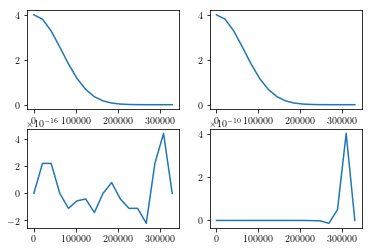

In [62]:
# make the same plots with the Theano output 

fig, ax = plt.subplots(nrows=2, ncols=2)

ax[0,0].plot(rfreqs, np.real(c_out))
ax[1,0].plot(rfreqs, np.imag(c_out))

ax[0,1].plot(rfreqs, np.abs(c_out))
ax[1,1].plot(rfreqs, 180 / np.pi * np.angle(c_out))

In [65]:
# from DiskJockey implementation, might be irrelevant if we use the `norm` rfft keyword for Theano
#    # We also want to normalize the result by the input array spacings, so that they are directly comparable with
#    # the analytic transforms (Numerical Recipes ed. 3, Press, Eqn 12.1.6)
#    out = dl * dm * rfft(fftshift(data))
#    return RawModelVis(lam, uu, vv, out)

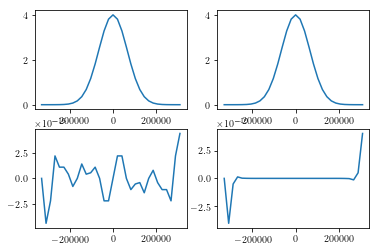

In [64]:
fig, ax = plt.subplots(nrows=2, ncols=2)

ax[0,0].plot(freqs, np.real(c_full))
ax[1,0].plot(freqs, np.imag(c_full))

ax[0,1].plot(freqs, np.abs(c_full))
ax[1,1].plot(freqs, 180 / np.pi * np.angle(c_full))

In [66]:
import theano.tensor as tt
import pymc3 as pm

with pm.Model() as model:

    # Parameters
    delta_alpha = pm.Uniform("delta_alpha", lower=-1*arcsec, upper=1*arcsec)
    sigma_alpha = pm.Uniform("sigma_alpha", lower=0.5*arcsec, upper=1.5*arcsec)
    
    # sky model 
    sky_model = pm.Deterministic("sky_model", tt.exp(-(alpha - delta_alpha)**2/(2 * sigma_alpha**2)))
    
    # compute the visibility model
    # define the Theano operation
    x = tt.matrix('x', dtype='float64')

    rfft = fft.rfft(x, norm=None)
    f_rfft = theano.function([x], rfft)

    # put in our Gaussian function, appropriately packed 
    box = np.zeros((1, N_alpha), dtype=np.float64) # shape (1, 32) because that's what Theano requires
    box[:] = np.fft.fftshift(sky_model)

    out = f_rfft(box)
    # out has dimensions of (1, N_alpha/2 + 1,2)

    c_out = np.asarray(out[0, :, 0] + 1j*out[0, :, 1]) # Assemble this into a numpy array of complex numbers

    # for the real fft (with real-valued input), the negative frequency terms are just the complex conjugates
    # of the positive frequency terms. So, we should reconstruct these into a single array.
    rfreqs = np.fft.rfftfreq(N_alpha, img_radius/(N_alpha))

    vis_model = rfft_to_full(c_out)                    
                                 
    # condition on observations
    pm.Normal("obs", mu=vis_model, sd=noise, observed=data)

ValueError: Cannot compute test value: input 0 (x) of Op Shape(x) missing default value.  
Backtrace when that variable is created:

  File "/home/ian/.build/anaconda/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ian/.build/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/ian/.build/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/home/ian/.build/anaconda/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/ian/.build/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ian/.build/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/ian/.build/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-66-67e330fef41f>", line 15, in <module>
    x = tt.matrix('x', dtype='float64')
